In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('fhs_train.csv')
df2 = pd.read_csv('fhs_test.csv')
print(df.head())
print(df.isnull().sum())

   Unnamed: 0  sex  age  education  currentSmoker  cigsPerDay  BPMeds  \
0        1267    1   58        1.0              0         0.0     0.0   
1        1209    0   40        1.0              1        15.0     0.0   
2        2050    0   52        1.0              0         0.0     0.0   
3        1183    1   38        2.0              1        43.0     0.0   
4        3225    0   43        1.0              0         0.0     0.0   

   prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                0             0         0    220.0  143.0  104.0  29.85   
1                0             0         0    199.0  122.0   82.0  22.16   
2                0             0         0    275.0  112.0   71.0  25.68   
3                0             1         0    170.0  130.0   94.0  23.90   
4                0             0         0    202.0  124.0   92.0  21.26   

   heartRate  glucose  TenYearCHD  
0         75     87.0           1  
1         85     77.0           

In [3]:
"""
#taking out the missing values results in a r2 or 0.02
rows_with_nan = np.isnan(df).any(axis=1)
df = df[~rows_with_nan]

#replacing missing values with the median results in a r2 0f 0.027
df['education'].fillna(df['education'].median(), inplace=True)
df['cigsPerDay'].fillna(df['cigsPerDay'].median(), inplace=True)
df['BPMeds'].fillna(df['BPMeds'].median(), inplace=True)
df['totChol'].fillna(df['totChol'].median(), inplace=True)
df['BMI'].fillna(df['BMI'].median(), inplace=True)
df['glucose'].fillna(df['glucose'].median(), inplace=True)
print(df.isnull().sum())

for column in df.columns:
    sns.kdeplot(df[column], label=column, shade=True)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(column)
    plt.legend()
    plt.show()
"""
#Using KNNImputer to fill in the missing values results in an r2 of 0.003
#BUT using KNN imputer and robust scaler results in an r2 of 0.073
#BUT using KNN imputer and standard scaler results in an r2 of 0.077
#Note to self: standard scaler only scales normal distributions... may want to dry different scaling distributions, like maxmin. 

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
imp = KNNImputer(n_neighbors=5)
ss = StandardScaler()
rs = RobustScaler()
print(df['TenYearCHD'].value_counts())
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
df2 = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
#df = pd.DataFrame(rs.fit_transform(df), columns=df.columns)
df = pd.DataFrame(ss.fit_transform(df), columns=df.columns)
d2 = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
print(df.isna().sum())
print(df['TenYearCHD'].value_counts())
df['TenYearCHD'][df['TenYearCHD']<0]=0
df['TenYearCHD'][df['TenYearCHD']>0]=1
df2['TenYearCHD'][df['TenYearCHD']<0]=0
df2['TenYearCHD'][df['TenYearCHD']>0]=1
print(df['TenYearCHD'].value_counts())

TenYearCHD
0    2693
1     487
Name: count, dtype: int64
Unnamed: 0         0
sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64
TenYearCHD
-0.425252    2693
 2.351547     487
Name: count, dtype: int64
TenYearCHD
0.0    2693
1.0     487
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
y_train = df['TenYearCHD']
X_train = df.drop('TenYearCHD',axis=1)
y_test = df2['TenYearCHD']
X_test = df2.drop('TenYearCHD',axis=1)


Best k: 199
R-squared of the best model: -0.07164471327416666


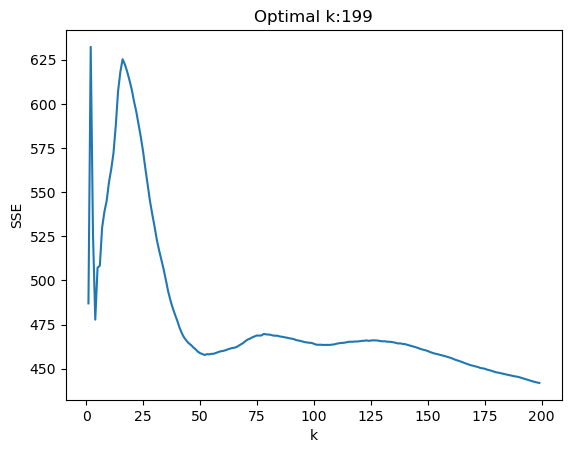

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

k_bar = 200
k_grid = np.arange(1, k_bar)
SSE = np.zeros(k_bar - 1)
r2_scores = np.zeros(k_bar - 1)

for k in range(k_bar - 1):
    fitted_model = KNeighborsRegressor(n_neighbors=k+1).fit(X_train, y_train)
    y_hat = fitted_model.predict(X_test)
    SSE[k] = np.sum((y_test - y_hat)**2)
    r2_scores[k] = r2_score(y_test, y_hat)

SSE_min = np.min(SSE)
min_index = np.argmin(SSE)
k_star = k_grid[min_index]
print("Best k:", k_star)

print("R-squared of the best model:", r2_scores[min_index])

plt.plot(np.arange(1, k_bar), SSE)
plt.xlabel("k")
plt.title("Optimal k:" + str(k_star))
plt.ylabel('SSE')
plt.show()
#not a very good r2... am going to have to make a lot of changes later on. 

In [ ]:
import itertools
from tqdm import tqdm
#Then I tried to mix-and-match a few variables, since putting them all together to the model was probably overcomplicating it. 
#After failing after a few combinations, I decided that this was too much work to do manually and decided to automate it. 
#Below is code written by myself and ChatGPT that brute forces every combination of 1 to 5 variables, and remembers the best r^2 value. 
#This code took about an hour to run. 
#As you can tell, this helped, but not much... increased r2 from 0.076 to 0.095. Yay!
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# List of all variable names
all_variables = list(X_train.columns)

best_r2 = -np.inf  # Initialize the best R-squared value
best_model = None  # Initialize the best model
best_features = None  # Initialize the best set of features
best_k = None  # Initialize the best value of k

k_bar = 50
k_grid = np.arange(1, k_bar)

# Total number of combinationslen(all_variables) + 1
total_combinations = sum(1 for r in range(1, 6) for _ in itertools.combinations(all_variables, r))

# Initialize tqdm with the total number of combinations
progress_bar = tqdm(total=total_combinations, desc="Progress", unit="combination")

# Iterate over all possible combinations of variableslen(all_variables) + 1
for r in range(1, 6):
    for variable_combination in itertools.combinations(all_variables, r):
        # Create a DataFrame with only the selected features
        X_train_subset = X_train[list(variable_combination)]
        X_test_subset = X_test[list(variable_combination)]
        
        # Train KNN model for each value of k
        SSE = np.zeros(k_bar)
        r2_scores = np.zeros(k_bar)
        for k in range(k_bar):
            fitted_model = KNeighborsRegressor(n_neighbors=k+1).fit(X_train_subset, y_train)
            y_hat = fitted_model.predict(X_test_subset)
            SSE[k] = np.sum((y_test - y_hat)**2)
            r2_scores[k] = r2_score(y_test, y_hat)

        # Find the optimal k for this combination of variables
        SSE_min = np.min(SSE)
        min_index = np.argmin(SSE)-1
        k_star = k_grid[min_index]

        # Check if this model is better than the current best model
        if r2_scores[min_index] > best_r2:
            best_r2 = r2_scores[min_index]
            best_model = fitted_model
            best_features = variable_combination
            best_k = k_star

        # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Print the results
print("Best combination of variables:", best_features)
print("Best k:", best_k)
print("Best R-squared:", best_r2)

# Plot SSE vs k for the best model
plt.plot(np.arange(0, k_bar), SSE)
plt.xlabel("k")
plt.title("Optimal k:" + str(best_k))
plt.ylabel('SSE')
plt.show()

"""
Best combination of variables: ('age', 'sysBP', 'BMI', 'glucose')
Best k: 48
Best R-squared: 0.09504864401653368
"""

Progress: 100%|█████████▉| 6868/6884 [3:05:43<00:28,  1.80s/combination]  